# International Air Passenger Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## Import data and basic analysis

In [2]:
air_passengers = pd.read_csv("data/AirPassengers.csv", header = 0, parse_dates = [0], infer_datetime_format=True,
                             names = ['Month', 'Passengers'], index_col = 0)


In [3]:
air_passengers.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
min(air_passengers.index)

Timestamp('1949-01-01 00:00:00')

In [5]:
max(air_passengers.index)

Timestamp('1960-12-01 00:00:00')

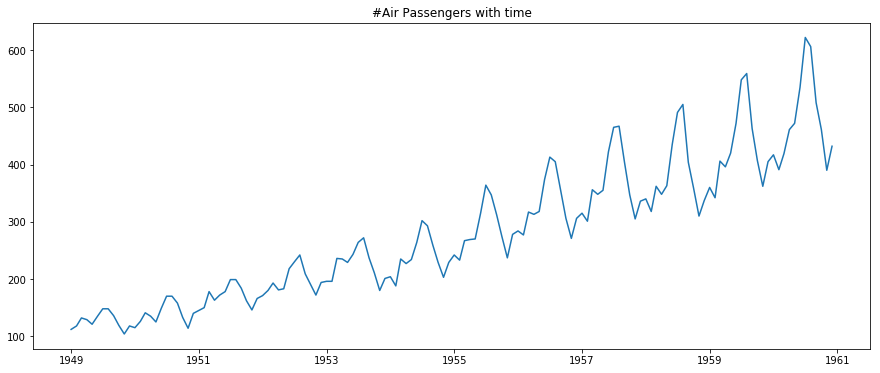

In [6]:
plt.plot(air_passengers)
plt.title('#Air Passengers with time')
plt.savefig('plots/ts_airpassenger_1.jpg')


# the plot clearly shows increase in variance of #passengers 
# with time, so lets take the log of the data to 
# penalize the higher magnitude values.

In [7]:
log_air_passengers = np.log(air_passengers)

In [8]:
log_air_passengers.head()

,Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


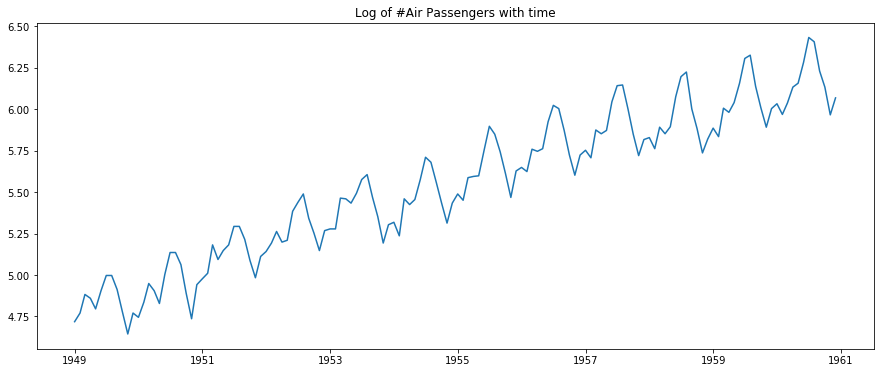

In [9]:
plt.plot(log_air_passengers)
plt.title('Log of #Air Passengers with time')
plt.savefig('plots/ts_airpassenger_2.jpg')

# we can now clearly see there is a upward trend
# and some seasonality effect

In [10]:
# lets difference the data with lag-1 so check for stationarity
log_air_passengers_diff = log_air_passengers - log_air_passengers.shift()

In [11]:
# the first value will be NaN as we have shifted the data.
log_air_passengers_diff.head()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022


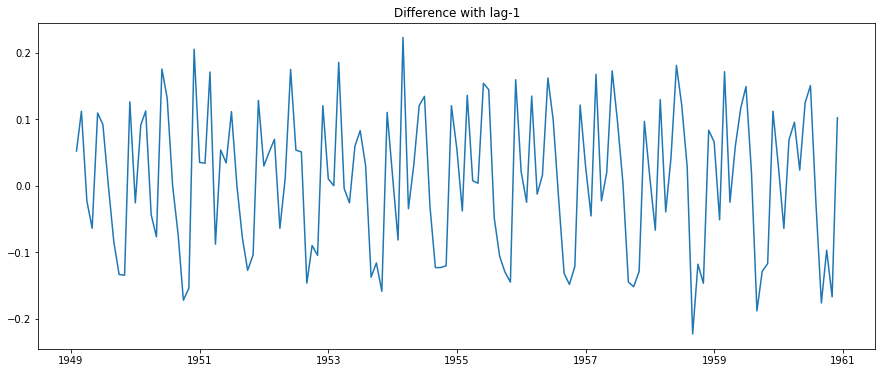

In [12]:
# now lets see if the data is stationary or not.
plt.plot(log_air_passengers_diff)
plt.title('Difference with lag-1')
plt.savefig('plots/ts_airpassenger_3.jpg')

In [13]:
# drop the NaN value
log_air_passengers_diff.dropna(inplace=True)

In [14]:
log_air_passengers_diff.head()

,Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484


In [15]:
log_air_passengers_diff.tail()

,Passengers
Month,
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083
1960-11-01,-0.167251
1960-12-01,0.102279


## Check stationarity of the data using Dickey-Fuller test

In [17]:
import pandas.tseries
from statsmodels.tsa.stattools import adfuller

In [22]:
# adfuller method works for 1d data so, the data should 
# either be a series or a 1d numpy array

# write a funtion to check the stationarity of the data.
def check_data_stationarity(data):
    
    fuller_results = adfuller(data['Passengers'])

    print('Fuller Statistics : {}'.format(fuller_results[0]))
    print('Fuller test P-value : {}'.format(fuller_results[1]))
    print('#lags used : {}'.format(fuller_results[2]))
    print('#observation used: {}'.format(fuller_results[3]))

    for key, value in fuller_results[4].items():
        print('Significance Level and value: {0}, : {1}:'.format(key, value))
        
    return

In [23]:
# check log data for stationarity
check_data_stationarity(log_air_passengers)

# the p-value is greater than critical value so
# we cannot reject the null hypothesis

# H0 - the series is not stationary
# H1 - the series is stationary

Fuller Statistics : -1.7170170891069605
Fuller test P-value : 0.42236677477039125
#lags used : 13
#observation used: 130
Significance Level and value: 1%, : -3.4816817173418295:
Significance Level and value: 5%, : -2.8840418343195267:
Significance Level and value: 10%, : -2.578770059171598:


In [24]:
# check log differenced data for stationarity

# the p-value is greater than critical value so
# we cannot reject the null hypothesis

# H0 - the series is not stationary
# H1 - the series is stationary

check_data_stationarity(log_air_passengers_diff)

Fuller Statistics : -2.7171305983881284
Fuller test P-value : 0.0711205481508595
#lags used : 14
#observation used: 128
Significance Level and value: 1%, : -3.4825006939887997:
Significance Level and value: 5%, : -2.884397984161377:
Significance Level and value: 10%, : -2.578960197753906:


In [25]:
from statsmodels.tsa.stattools import acf, pacf

In [26]:
# lets look at the acf and pacf plots of log data
lag_acf = acf(log_air_passengers.values, nlags = 30)
lag_pacf = pacf(log_air_passengers.values, nlags = 30)

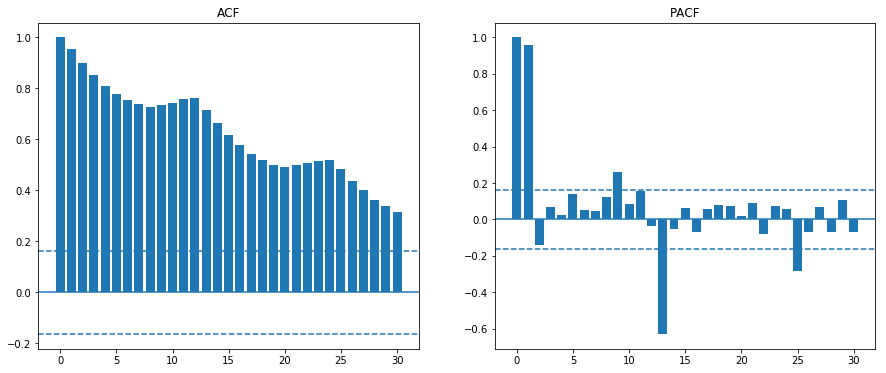

In [27]:
## for log transformed data..

# Auto-Correlation Function to check MA process 
plt.subplot(121) 
plt.bar(range(len(lag_acf)), height = lag_acf)
plt.axhline(y=0, linestyle='-')
plt.title('ACF')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers)), linestyle='--')

# look at where the plot crosses the upper confidence interval for the first time
# for ACF this is 1 and gives us the p value

# Partial Auto-Correlation Function to check AR process
plt.subplot(122) 
plt.bar(range(len(lag_pacf)), height = lag_pacf)
plt.axhline(y=0, linestyle='-')
plt.title('PACF')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers)), linestyle='--')

plt.savefig('plots/ts_airpassenger_3.jpg')
# look at where the plot crosses the upper confidence interval for the first time
# for PACF this is 2 and gives us the p value

### acf plot:
    # 1. definately some seasonality (yearly) for ma(q) process
    # 2. check the difference data
### pacf plot:
    # 1. lag 1 and lag 12 are significant, so, ar(1) process and sar(1)
    # 2. lag is significant for lag 8 or 9
    # 3. check the difference data

In [30]:
# log transformed data
d_lag_acf = acf(log_air_passengers_diff.values, nlags = 30)
d_lag_pacf = pacf(log_air_passengers_diff.values, nlags = 30)

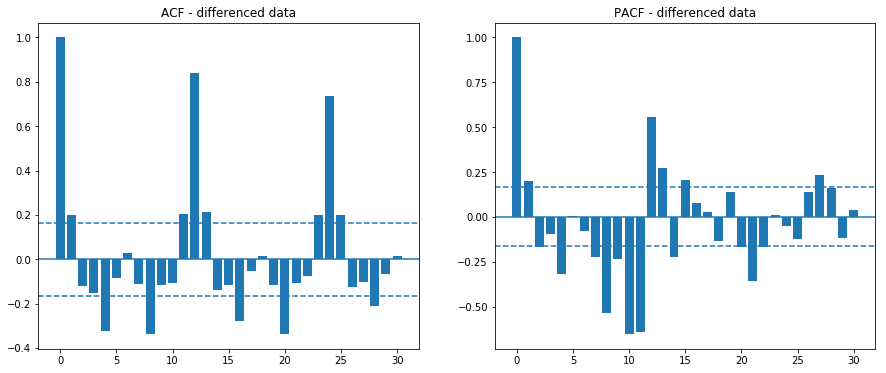

In [31]:
## for differenced log data..

# Auto-Correlation Function to check MA process 
plt.subplot(121) 
plt.bar(range(len(d_lag_acf)), height = d_lag_acf)
plt.axhline(y=0, linestyle='-')
plt.title('ACF - differenced data')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)), linestyle='--')

# Partial Auto-Correlation Function to check AR process
plt.subplot(122) 
plt.bar(range(len(d_lag_acf)), height = d_lag_pacf)
plt.axhline(y=0, linestyle='-')
plt.title('PACF - differenced data')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)), linestyle='--')

plt.savefig('plots/ts_airpassenger_4.jpg')

### acf plot:
    # 1. yearly and might be quaterly seasonality for ma(q) process
### pacf plot:
    # 1. lag 1 and lag 12 are significant, so, ar(1) process and sar(1)
    # 2. lag is significant for lag 8 or 9
    
### Observation: 
    1. It is not clear about the actual process that can be applied using
       the above details, so we will have to use some more exploration techniques.
    2. Let try to fit ARIMA models then we can check Exponential Weighted Moving Average(EWMA)

## forecasting

In [33]:
from statsmodels.tsa.arima_model import ARIMA

In [42]:
## ARIMA model

# the parameter order has 3 components :
# 1. The number of Auto-Regressive Terms (p)
# 2. The number of differences taken (d)
# 3. The number of Moving Average Terms (q)

def arima_model_fitting(raw_data, diff_data, pdq = (), plotting = True):
    
    model = ARIMA(log_air_passengers, order= pdq)  
    results = model.fit(disp=-1)  

    if plotting:
        plt.plot(diff_data)
        plt.plot(results.fittedvalues, color='red')
        rss_value = sum((results.fittedvalues - diff_data['Passengers'])**2)
        plt.title('Residual SSE : {} '.format(rss_value))
    else:
        return results.fittedvalues

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


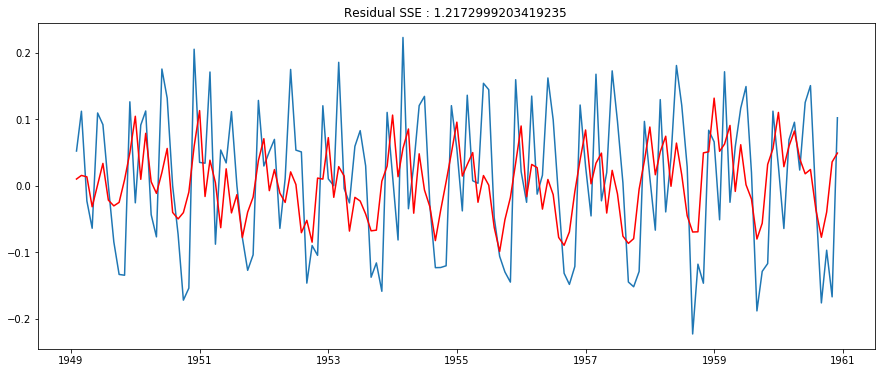

In [43]:
## AR(1) + MA(2) + 1 difference

arima_model_fitting(log_air_passengers, log_air_passengers_diff, pdq = (1, 1, 2))

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


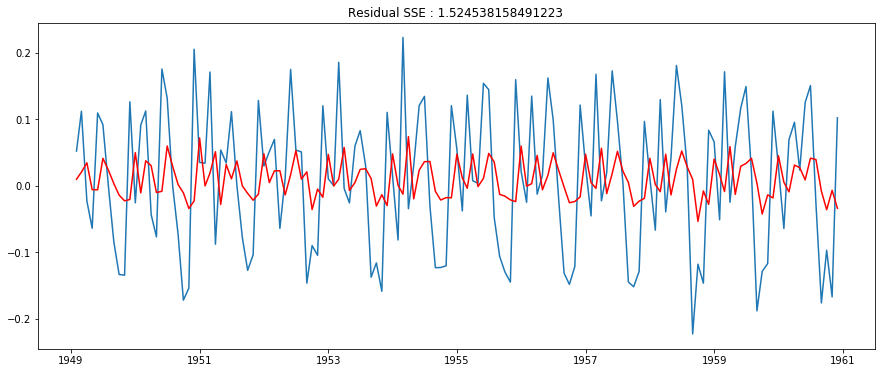

In [44]:
## AR(0) + MA(1) + 1 difference

arima_model_fitting(log_air_passengers, log_air_passengers_diff, pdq = (0, 1, 1))

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


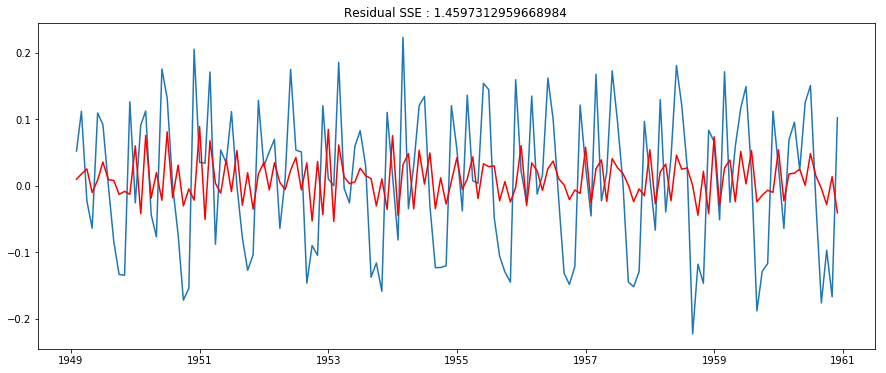

In [45]:
## AR(1) + MA(1) + 1 difference

arima_model_fitting(log_air_passengers, log_air_passengers_diff, pdq = (1, 1, 1))

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


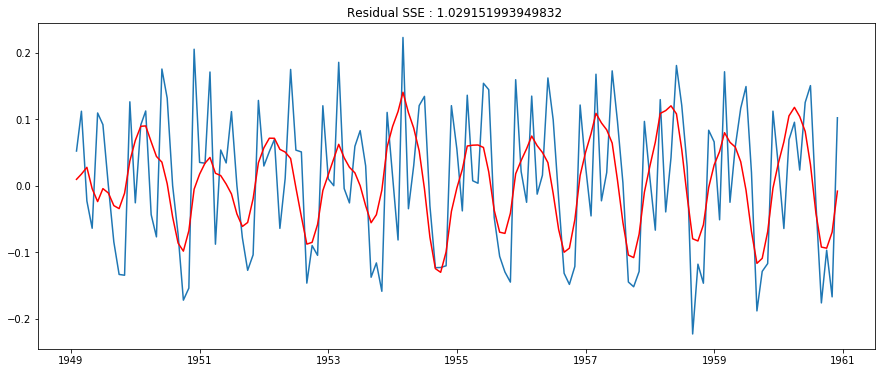

In [47]:
## AR(2) + MA(2) + 1 difference

arima_model_fitting(log_air_passengers, log_air_passengers_diff, pdq = (2, 1, 2))

In [65]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009800
1949-03-01    0.017618
1949-04-01    0.025229
1949-05-01   -0.010225
1949-06-01    0.008528
dtype: float64


In [66]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009800
1949-03-01    0.027418
1949-04-01    0.052648
1949-05-01    0.042422
1949-06-01    0.050950
dtype: float64


In [67]:
# just getting the index
predictions_ARIMA_log = pd.Series(log_air_passengers.iloc[0], index=log_air_passengers.index)
predictions_ARIMA_log.head()

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
Name: 1949-01-01 00:00:00, dtype: float64

In [68]:
predictions_ARIMA_log = pd.Series(log_air_passengers.ix[0], index=log_air_passengers.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01         NaN
1949-02-01    0.009800
1949-03-01    0.027418
1949-04-01    0.052648
1949-05-01    0.042422
dtype: float64

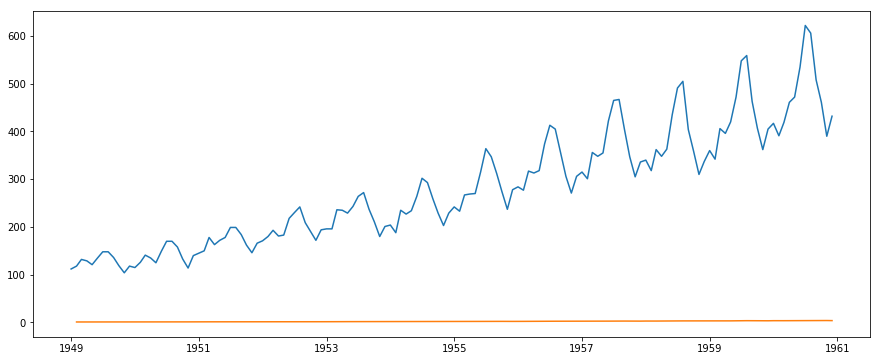

In [69]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(air_passengers)
plt.plot(predictions_ARIMA)